<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/q_finance/portfolio_diversification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install -q qiskit-aer
!pip install -q qiskit-machine-learning
!pip install -q qiskit-finance
!pip install -q qiskit-optimization
!pip install -q qiskit-nature

In [2]:
!pip install -q cplex

In [3]:
#  Import requisite modules
import math
import datetime

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import Qiskit packages
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# The data providers of stock-market data
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioDiversification

<ipython-input-3-4ec4446d5df6>:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE


In [4]:
# Generate a pairwise time-series similarity matrix
seed = 123

stocks = ["TICKER1", "TICKER2"]
n = len(stocks)

data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
rho = data.get_similarity_matrix()

In [5]:
rho

array([[1.00000000e+00, 7.79571614e-04],
       [7.79571614e-04, 1.00000000e+00]])

In [6]:
q = 1  # q less or equal than n

In [7]:
class ClassicalOptimizer:
    def __init__(self, rho, n, q):

        self.rho = rho
        self.n = n  # number of inner variables
        self.q = q  # number of required selection

    def compute_allowed_combinations(self):
        f = math.factorial
        return int(f(self.n) / f(self.q) / f(self.n - self.q))

    def cplex_solution(self):

        # refactoring
        rho = self.rho
        n = self.n
        q = self.q

        my_obj = list(rho.reshape(1, n**2)[0]) + [0.0 for x in range(0, n)]
        my_ub = [1 for x in range(0, n**2 + n)]
        my_lb = [0 for x in range(0, n**2 + n)]
        my_ctype = "".join(["I" for x in range(0, n**2 + n)])

        my_rhs = (
            [q]
            + [1 for x in range(0, n)]
            + [0 for x in range(0, n)]
            + [0.1 for x in range(0, n**2)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 1 + n)])
            + "".join(["E" for x in range(0, n)])
            + "".join(["L" for x in range(0, n**2)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        col = [x for x in range(n**2, n**2 + n)]
        coef = [1 for x in range(0, n)]
        rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        for ii in range(0, n):
            col = [ii * n + ii, n**2 + ii]
            coef = [1, -1]
            rows.append([col, coef])

        for ii in range(0, n):
            for jj in range(0, n):
                col = [ii * n + jj, n**2 + jj]
                coef = [1, -1]

                rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [8]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(rho, n, q)

# Compute the number of feasible solutions:
print("Number of feasible combinations= " + str(classical_optimizer.compute_allowed_combinations()))

# Compute the total number of possible combinations (feasible + unfeasible)
print("Total number of combinations= " + str(2 ** (n * (n + 1))))

Number of feasible combinations= 2
Total number of combinations= 64


In [9]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color="r")

    plt.grid()

    for ii in range(n**2, n**2 + n):

        if x[ii] > 0:
            plt.plot(xc[ii - n**2], yc[ii - n**2], "r*", ms=20)

    for ii in range(0, n**2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], "C2")

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

In [10]:
from qiskit.utils import algorithm_globals


class QuantumOptimizer:
    def __init__(self, rho, n, q):
        self.rho = rho
        self.n = n
        self.q = q
        self.pdf = PortfolioDiversification(similarity_matrix=rho, num_assets=n, num_clusters=q)
        self.qp = self.pdf.to_quadratic_program()

    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        exact_mes = NumPyMinimumEigensolver()
        exact_eigensolver = MinimumEigenOptimizer(exact_mes)
        result = exact_eigensolver.solve(self.qp)
        return self.decode_result(result)

    def vqe_solution(self):
        algorithm_globals.random_seed = 100
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(n, "ry", "cz", reps=5, entanglement="full")
        vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
        vqe = MinimumEigenOptimizer(vqe_mes)
        result = vqe.solve(self.qp)
        return self.decode_result(result)

    def qaoa_solution(self):
        algorithm_globals.random_seed = 1234
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(self.qp)
        return self.decode_result(result)

    def decode_result(self, result, offset=0):
        quantum_solution = 1 - (result.x)
        ground_level = self.qp.objective.evaluate(result.x)
        return quantum_solution, ground_level

In [11]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(rho, n, q)

In [12]:
try:
    import cplex

    # warnings.filterwarnings('ignore')
    quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
    print(quantum_solution, quantum_cost)
    classical_solution, classical_cost = classical_optimizer.cplex_solution()
    print(classical_solution, classical_cost)
    if np.abs(quantum_cost - classical_cost) < 0.01:
        print("Binary formulation is correct")
    else:
        print("Error in the formulation of the Hamiltonian")
except Exception as ex:
    print(ex)

[0. 1. 0. 1. 0. 1.] 1.000779571614484
[1. 0. 1. 0. 1. 0.] 1.000779571614484
Binary formulation is correct


In [13]:
ground_state, ground_level = quantum_optimizer.exact_solution()
print(ground_state)
classical_cost = 1.000779571614484  # obtained from the CPLEX solution

try:
    if np.abs(ground_level - classical_cost) < 0.01:
        print("Ising Hamiltonian in Z basis is correct")
    else:
        print("Error in the Ising Hamiltonian formulation")
except Exception as ex:
    print(ex)

[0. 1. 0. 1. 0. 1.]
Ising Hamiltonian in Z basis is correct


In [14]:
vqe_state, vqe_level = quantum_optimizer.vqe_solution()
print(vqe_state, vqe_level)

try:
    if np.linalg.norm(ground_state - vqe_state) < 0.01:
        print("SamplingVQE produces the same solution as the exact eigensolver.")
    else:
        print(
            "SamplingVQE does not produce the same solution as the exact eigensolver, but that is to be expected."
        )
except Exception as ex:
    print(ex)

[1. 0. 1. 0. 1. 0.] 1.000779571614484
SamplingVQE does not produce the same solution as the exact eigensolver, but that is to be expected.


In [15]:
xc, yc = data.get_coordinates()

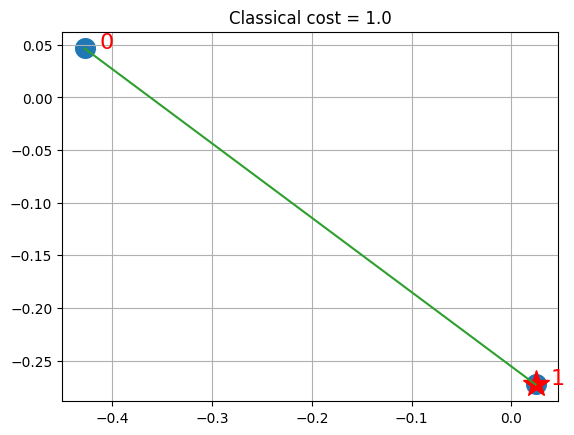

In [16]:
visualize_solution(xc, yc, ground_state, ground_level, n, q, "Classical")

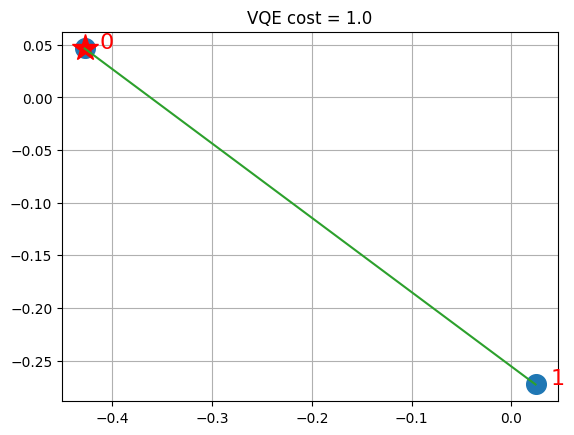

In [17]:
visualize_solution(xc, yc, vqe_state, vqe_level, n, q, "VQE")